In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import datetime, timedelta, timezone
from datetime import timezone
sys.path.append('/home/manu/TFG_repo/scripts')

In [3]:
from config import data_dir
from analysis_functions import *
from gen_time_series_better import datenum_to_epoch, get_SBE
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

#### Cargamos directamente las fechas de los dos SBE37 y de uno de los SB56 (sabemos que los SBE56 están sincronizados)

In [55]:
datafile1 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE37' / 'SBE37346520190409.mat'
datafile2 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE37' / 'SBE37567420190409.mat'
datafile3 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE56' / 'AGL_SBE05600218_2019-04-09.mat'

In [56]:
up_37_mat = np.squeeze(loadmat(datafile2)['dates'])
dwn_37_mat = np.squeeze(loadmat(datafile1)['dates'])
date_56_mat = np.squeeze(loadmat(datafile3)['dates'])

up_37_epoch = list(map(datenum_to_epoch, up_37_mat))
dwn_37_epoch = list(map(datenum_to_epoch, dwn_37_mat))
date_56_epoch = list(map(datenum_to_epoch, date_56_mat))

up_37 = np.array([datetime.utcfromtimestamp(i) for i in up_37_epoch])
dwn_37 = np.array([datetime.utcfromtimestamp(i) for i in dwn_37_epoch])
date_56 = np.array([datetime.utcfromtimestamp(i) for i in date_56_epoch])

KeyboardInterrupt: 

### Sincronización relativa entre los dos SBE37 

In [ ]:
print('Up_37 va desde {} hasta {}, con un total de {} medidas'.format(up_37[0], up_37[-1], len(up_37)))
print('dwn_37 va desde {} hasta {}, con un total de {} medidas'.format(dwn_37[0], dwn_37[-1], len(dwn_37)))
print('date_56 va desde {} hasta {}, con un total de {} medidas'.format(date_56[0], date_56[-1], len(date_56)))
print('Dwn_37 va desde {} hasta {}, con un total de {} medidas'.format(dwn_37[0], dwn_37[-1], len(dwn_37)))
print('Medidas en dwn_37 que no tienen un periodo de 5 minutos? (idx):',
      (dwn_37[1:] - dwn_37[:-1] != timedelta(minutes=5)).nonzero()[0])
print('Medidas en up_37 que no tienen un periodo de 10 minutos? (idx):',
     (up_37[1:] - up_37[:-1] != timedelta(minutes=10)).nonzero()[0])
print('Medidas en date_56 que no tienen un periodo de 5 segundos? (idx):',
     (date_56[1:] - date_56[:-1] != timedelta(seconds=5)).nonzero()[0])

In [7]:
a = np.nonzero(np.in1d(up_37, dwn_37))[0] # indices de las coincidencias de up_37 en dwn_37
b = np.nonzero(np.in1d(dwn_37, up_37))[0] # indices de las coincidencias de dwn_37 en up_37

In [8]:
print('Up_37 tiene {} coincidencias en dwn_37'.format(len(a))) 

Up_37 tiene 20719 coincidencias en dwn_37


A la vista de lo anterior, se observa que toda las medidas de up_37 coinciden con una medida en dwn_37, excepto la última. De la libreta AGL_1_cleansing sabemos que los termistores salieron del agua el día 8, por lo que la serie temporal total se cortará en el punto indicado en dicha libreta (medida 2471040 para los 56). 

En la serie AGL_1 de SBE56, sincronizada totalmente para todos los termistores, entre la entrada 122 y la 123 el periodo es de 4 segundos. De aquí en adelante pasa a ser 5 segundos otra vez. Como la serie empieza en una hora redonda (11:00:00) y hasta la medida 122 el periodo es de 5 segundos, de la medida 123 en adelante, la hora de los SBE56 nunca coincidirá con la de los SB37, que siempre es múltiplos de 5 minutos, segundos a 0. Para solucionar esto y poder sincronizar los SBE56 y 37 podemos añadir un timedelta de 1 segundo a la serie de SBE56, ya que no vamos a estudiar fenómenos a tan altas frecuencias como para que 1 segundo de disparidad afecte gravemente.

In [53]:
path_SBE56 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE56'
pres_SBE56 = np.array([1, 8, 23, 28, 33, 43, 53, 63, 78, 96, 108, 126, 
                           151, 176])
order_SBE56 = ['0218', '5894', '0221', '5895', '0222', '0225', '0226',
                   '5897', '5899', '0235', '5900', '5901', '5902', '5903']
temp_SBE56, pres_SBE56, date_SBE56 = get_SBE(path_SBE56, pres_SBE56, 
                                                 order_SBE56, n_max=2471041)

datafile_low_SBE37 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE37' / 'SBE37346520190409.mat'
datafile_up_SBE37 = data_dir / 'raw' / 'thermistor_chain' / 'AGL_1' / 'SBE37' / 'SBE37567420190409.mat'
up_SBE37 =  loadmat(datafile_up_SBE37)
low_SBE37 = loadmat(datafile_low_SBE37)
temp_up_SBE37, date_up_SBE37 = np.squeeze(up_SBE37['tem']), np.squeeze(up_SBE37['dates'])
temp_low_SBE37, date_low_SBE37 = np.squeeze(low_SBE37['tem']), np.squeeze(low_SBE37['dates'])
date_up_SBE37 = datenum_to_epoch(date_up_SBE37)
date_low_SBE37 = datenum_to_epoch(date_low_SBE37)

2487606 2490629
All SBE56 dates are synced. Generating 1d dates array


In [57]:
press_low_SBE37, press_up_SBE37 = np.squeeze(low_SBE37['pre']), np.squeeze(up_SBE37['pre'])

In [58]:
# para poner los SBE56 con el mismo año que los 37
date_SBE56 -= int(timedelta(days=365).total_seconds())

In [59]:
date_SBE56[123:] += 1

In [62]:
#max_up_37 = np.argmax((temp_SBE37[0] == temp_SBE56)[::-1])
last_up = np.nonzero(np.in1d(date_SBE56, date_up_SBE37))[0][-1] # indices de las coincidencias de up_37 en dwn_37
last_low = np.nonzero(np.in1d(date_SBE56, date_low_SBE37))[0][-1] # indices de las coincidencias de up_37 en dwn_37

In [63]:
# array de temperaturas
masked_temp = np.ma.masked_all_like(np.zeros((len(date_SBE56), 16)))
masked_temp[:, 0:6] = temp_SBE56[:, 0:6]
masked_temp[0:last_up+1:120, 6] = temp_up_SBE37[:np.where(date_up_SBE37 == date_SBE56[last_up])[0][0] +1]
masked_temp[0:last_low+1:60, -1] = temp_low_SBE37[:np.where(date_low_SBE37 == date_SBE56[last_low])[0][0] +1]
masked_temp[:, 7:-1] = temp_SBE56[:, 6:]

In [64]:
print('Cada 120 elementos (10 min) de masked temp, hay 16 medidas:', (masked_temp[::120].count(axis=1)==16).all())
print('Cada 60 elementos (5 min) de masked temp, hay 15 medidas o más:', (masked_temp[::60].count(axis=1) >= 15).all())

Cada 120 elementos (10 min) de masked temp, hay 16 medidas: True
Cada 60 elementos (5 min) de masked temp, hay 15 medidas o más: True


In [65]:
# array de presiones
masked_pres = np.ma.masked_all_like(masked_temp)
masked_pres[:, 0:6] = pres_SBE56[None, :6]
masked_pres[0:last_up+1:120, 6] = press_up_SBE37[:np.where(date_up_SBE37 == date_SBE56[last_up])[0][0] +1]
masked_pres[:, 7:-1] = pres_SBE56[None, 6:]
masked_pres[0:last_low+1:60, -1] = press_low_SBE37[:np.where(date_low_SBE37 == date_SBE56[last_low])[0][0] +1]

In [66]:
from netCDF4 import Dataset

In [26]:
filename = data_dir / 'time_series' / 'processed' / 'AGL_1_37_56.nc'
dim_pres = masked_pres.shape[1]
dim_time = len(date_SBE56)
with Dataset(filename, mode='w', format='NETCDF4') as ds:
    ds.description = 'Time series of AGL buy thermistor chain from 2018-11-16 11:00:00 to 2019-04-08 11:00:00'
    
    # dimensions
    ds.createDimension('time', dim_time)
    ds.createDimension('pres', dim_pres)
    
    # variables
    temp = ds.createVariable('temp', 'f8', ('time', 'pres',))
    date = ds.createVariable('date', 'i4', ('time', ))
    pres = ds.createVariable('pres', 'i4', ('time', 'pres', ))
    
    # asign data
    temp[:, :] = masked_temp
    date[:] = date_SBE56
    pres[:, :] = masked_pres

[13.3992 -- -- ... -- -- --]


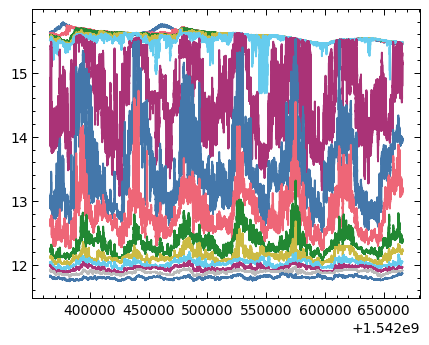

In [50]:
with Dataset(filename, mode='r') as ds:
    temp = ds['temp'][:]
    print(temp[:, 6])
    date = ds['date'][:]
    fig, ax = plt.subplots()
    ax.plot(date[:60000], temp[:60000])